In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

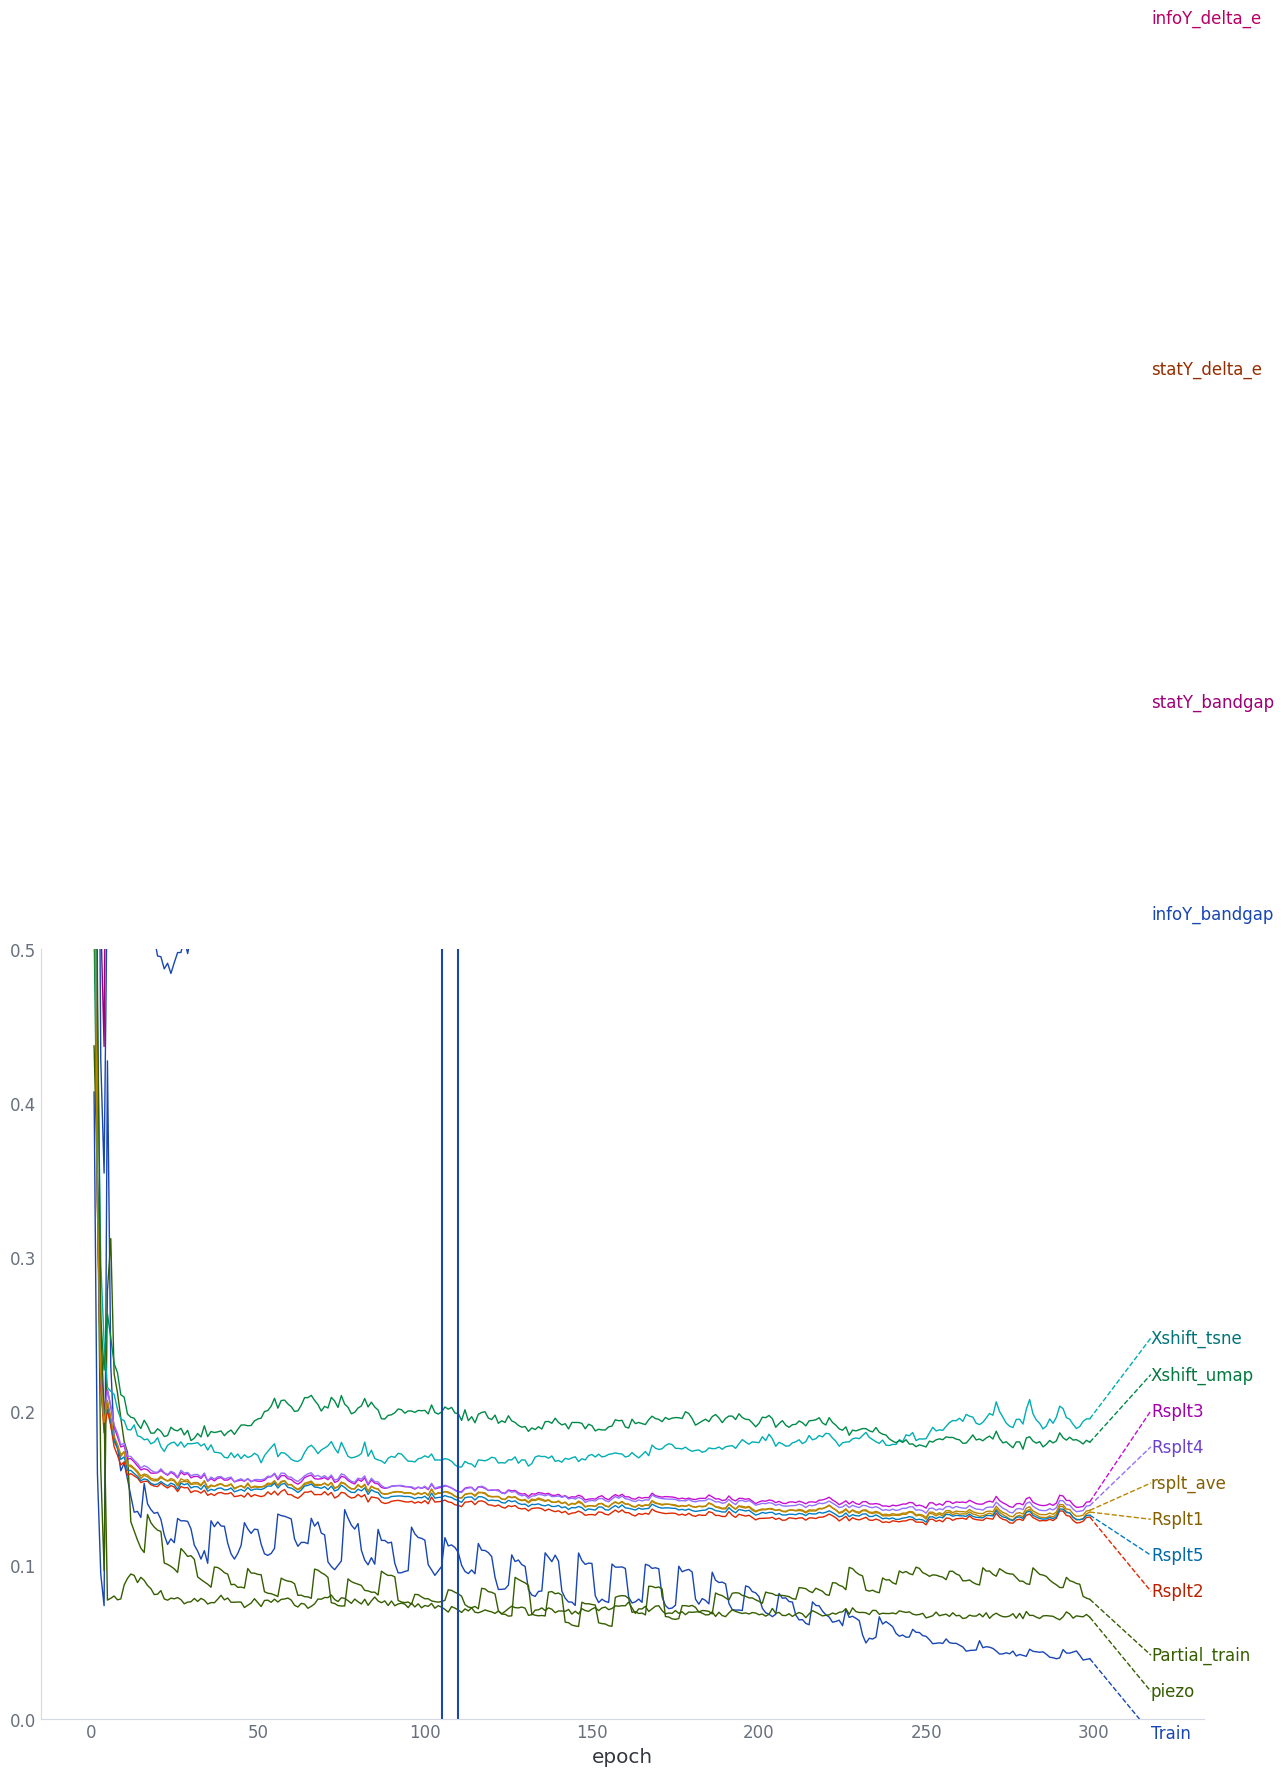

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
df = pd.read_feather('exps/delta_e_02-19-13-48/SAL-training_loss.feather')
df.set_index('epoch').plot(ax=ax, lw=1)
ax.set_ylim(0, 0.5)
# rp.smooth_noisy_lines(keep_old_line=False)
# rp.smooth_straight_lines
ax.axvline(105)
ax.axvline(110)
rp.line_labels()
# df.set_index('epoch').map(lambda x: np.log10(x + 1)).plot(ax=ax, alpha=0.05, lw=0.2, legend=None)


In [3]:
fig, ax = plt.subplots(figsize=(15, 10))
df = pd.read_feather('exps/delta_e_piezo/SAL-training_loss.feather').query('epoch > 1')
df.set_index('epoch').plot(ax=ax)
# rp.smooth_noisy_lines(keep_old_line=False)
rp.line_labels()
# df.set_index('epoch').map(lambda x: np.log10(x + 1)).plot(ax=ax, alpha=0.05, lw=0.2, legend=None)

NameError: name 'plt' is not defined

In [9]:
df['rsplt_ave'].cummin()

1     0.338848
2     0.222275
3     0.192258
4     0.192258
5     0.192258
6     0.192100
7     0.192100
8     0.192100
9     0.192100
10    0.192100
11    0.192100
12    0.192100
13    0.192100
14    0.192100
15    0.192100
16    0.192100
17    0.192100
18    0.192100
19    0.192100
20    0.192100
21    0.192100
22    0.192100
23    0.192100
24    0.192100
25    0.192100
26    0.192100
27    0.192100
28    0.192100
29    0.192100
30    0.192100
31    0.192100
32    0.192100
33    0.192100
34    0.192100
35    0.192100
36    0.192100
37    0.192100
38    0.192100
39    0.192100
40    0.192100
41    0.192100
42    0.192100
43    0.192100
44    0.192100
45    0.192100
46    0.192100
47    0.192100
48    0.192100
49    0.192100
50    0.192100
51    0.192100
52    0.192100
53    0.192100
54    0.192100
55    0.192100
Name: rsplt_ave, dtype: float64